# Fiducial Segmentation Reproducibility
_Produces Supplemental figure S5 and S6._

We have two repeated axial scans acquired in each session. With the assumption that no movement has occured between the scans, and that the geometric distortions are stable over such short time period (a fair assumption), we can use the segmentations obtained from these two scans to estimate the precision in our segmentations.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('../data/distortions_df.csv', low_memory=False)
df = df[df['Method']=='UNetAxisRigid']
df.drop(df[(df['Subject'] == 'P0020') & (df['Session'] == '20240322121526')].index, inplace=True)

df['LabelValue'] = df['LabelValue'].astype(int)

df.head()

,LabelValue,x_org,y_org,z_org,x_ref,y_ref,z_ref,x_reg,y_reg,z_reg,x_diff,y_diff,z_diff,Axis,Run,Subject,Session,Method
54,1,85.0,54.400001,-49.600001,0.0,50.0,50.0,-0.392082,49.621128,47.854862,0.392082,0.378872,2.145138,sag,1,P0003,20230927164642,UNetAxisRigid
55,2,135.0,102.400002,-48.000001,-50.0,0.0,50.0,-50.006134,1.264694,50.435455,0.006134,-1.264694,-0.435455,sag,1,P0003,20230927164642,UNetAxisRigid
56,3,85.0,155.200002,-51.200001,0.0,-50.0,50.0,0.415276,-51.187340,48.303493,-0.415276,1.187340,1.696507,sag,1,P0003,20230927164642,UNetAxisRigid
57,4,35.0,104.000002,-49.600001,50.0,0.0,50.0,50.003548,0.433365,48.857220,-0.003548,-0.433365,1.142780,sag,1,P0003,20230927164642,UNetAxisRigid
58,5,85.0,104.000002,-49.600001,0.0,0.0,50.0,0.005150,0.032959,48.862755,-0.005150,-0.032959,1.137245,sag,1,P0003,20230927164642,UNetAxisRigid


We load the dataset and pull out the scans labeled `UNetAxisRigid` which corresponds to the UNet segmentation model which is designed for the three scan plans, and which use a rigid body registration to the design space. We remove one session which returned NaN values in the difference calculation.

Next we calculate the difference between the two scans and evaluate it in the three directions and magnitude in-plane (2D) and in 3D

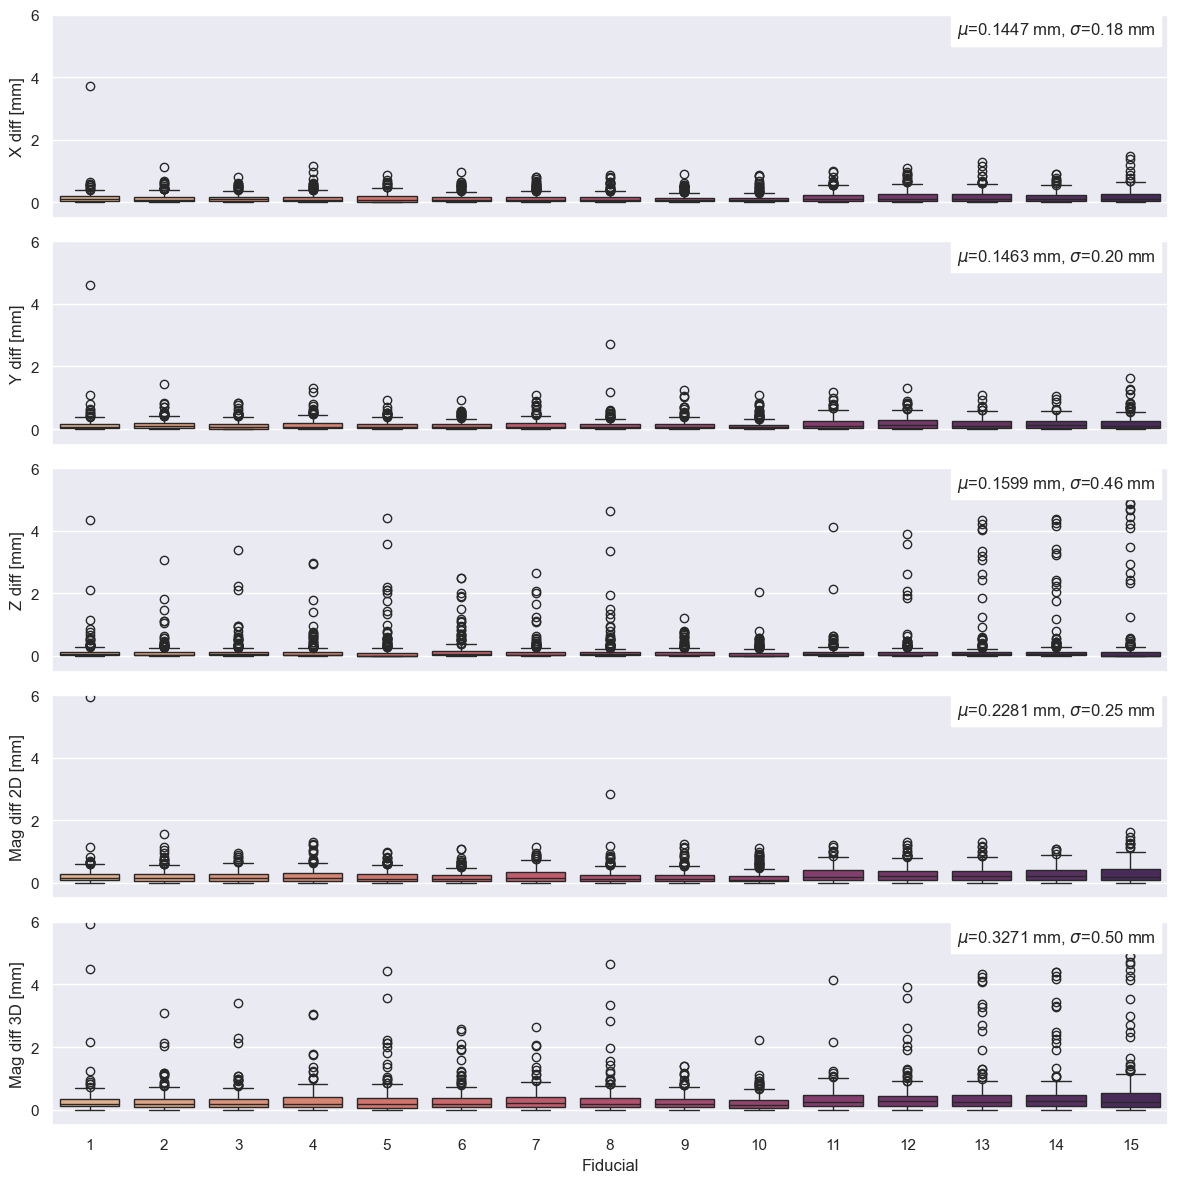

In [3]:
df_pivot = df[(df.Axis == 'axi')].pivot(index=['Subject','LabelValue', 'Session'], columns='Run')
diff_x = df_pivot[('x_reg', 1)] - df_pivot[('x_reg', 2)]
diff_y = df_pivot[('y_reg', 1)] - df_pivot[('y_reg', 2)]
diff_z = df_pivot[('z_reg', 1)] - df_pivot[('z_reg', 2)]
diff_mag_2D = np.sqrt(diff_x**2 + diff_y**2)
diff_mag_3D = np.sqrt(diff_x**2 + diff_y**2 + diff_z**2)

diff_df = pd.DataFrame({'X':diff_x, 'Y':diff_y, 'Z':diff_z, 'absX':abs(diff_x), 'absY':abs(diff_y), 'absZ':abs(diff_z), 'Mag2D':diff_mag_2D, 'Mag3D':diff_mag_3D})

sns.set_theme()
fig, axes = plt.subplots(5,1,figsize=(12,12))

text_y = [5.5]*5
for i,k in enumerate(['absX', 'absY', 'absZ', 'Mag2D', 'Mag3D']):
    sns.boxplot(diff_df, x='LabelValue', y=k, hue='LabelValue', legend=None, ax=axes[i], palette='flare')
    axes[i].text(13,text_y[i],fr"$\mu$={diff_df[k].mean():.4f} mm, $\sigma$={diff_df[k].std():.2f} mm", 
                 horizontalalignment='center', verticalalignment='center', backgroundcolor='w')

for i in range(4):
    axes[i].set_xlabel(None)
    axes[i].set_xticks([])

for ax in axes:
    ax.set_ylim([-.5,6])

axes[3].set_ylim([-.5,6])
axes[4].set_ylim([-.5,6])

axes[0].set_ylabel('X diff [mm]')
axes[1].set_ylabel('Y diff [mm]')
axes[2].set_ylabel('Z diff [mm]')
axes[3].set_ylabel('Mag diff 2D [mm]')
axes[4].set_ylabel('Mag diff 3D [mm]')
axes[4].set_xlabel('Fiducial')

plt.tight_layout()
plt.show()

From these box plots with data arrange by fiducial we don't see a clear variation between fiducials. What we are mainly interested in is how big the variations in the segmentations are per axis. For this we calculate the histograms of the errors in X, Y, and Z, and calculate histogram parameters.

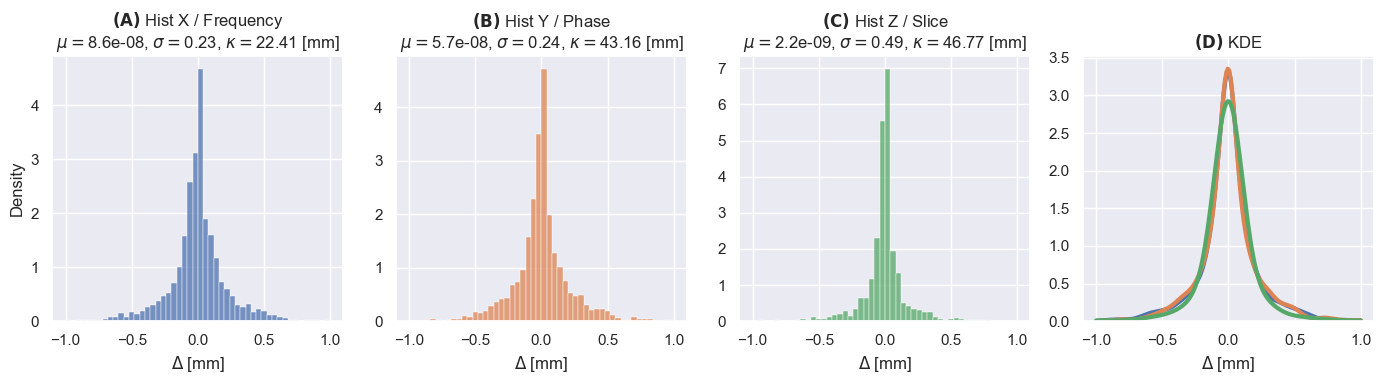

In [4]:
fig, axes = plt.subplots(1,4, figsize=(14,4))
sns.histplot(data=diff_df, x='X', binrange=[-1,1],  ax=axes[0], bins=50, stat='density', color='C00', legend=r'$\kappa$')
sns.histplot(data=diff_df, x='Y', binrange=[-1,1],  ax=axes[1], bins=50, stat='density', color='C01')
sns.histplot(data=diff_df, x='Z', binrange=[-1,1],  ax=axes[2], bins=50, stat='density', color='C02')

sns.kdeplot(data=diff_df, x='X', clip=[-1,1], ax=axes[3], linewidth=3)
sns.kdeplot(data=diff_df, x='Y', clip=[-1,1], ax=axes[3], linewidth=3)
sns.kdeplot(data=diff_df, x='Z', clip=[-1,1], ax=axes[3], linewidth=3)

for ax in axes:
    ax.set_xlabel(r'$\Delta$ [mm]')

for ax in axes[1:]:
    ax.set_ylabel(None)
    # ax.set_yticklabels([])

subplot_lab = ['A', 'B', 'C']
enc_dir = ['Frequency', 'Phase', 'Slice']

for i,ax in enumerate(['X', 'Y', 'Z']):
    mstr = f"$\mu=${diff_df[ax].mean():.1e}"
    sdstr = f"$\sigma=${diff_df[ax].std():.2f}"
    kstr = f"$\kappa=${diff_df[ax].kurtosis():.2f}"
    axes[i].set_title(r"$\bf{" + f"({subplot_lab[i]})" + "}$" f" Hist {ax} / {enc_dir[i]}\n" + f"{mstr}, {sdstr}, {kstr} [mm]")

axes[3].set_title(r'$\bf{(D)}$ KDE')

plt.tight_layout()
plt.savefig('../results/figureS5_nnUNet_reprod_axis.png', dpi=300)

plt.show()

Here we see that the mean is very close to 0 for all axes, but that $\sigma$ is twice as large for the Z axis, as expected when we have such thick slices. We also have higher kurtosis in the phase and slice direction compared to the frequency encoding. We can also look at the error in 2D and 3D, where 3D is calculated in the high-resolution plane (frequency and phase).

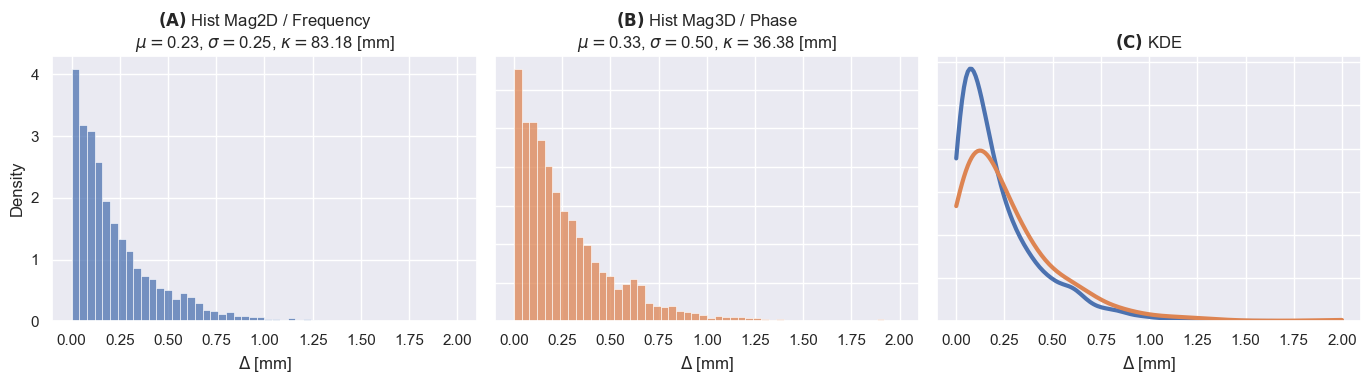

In [5]:
fig, axes = plt.subplots(1,3, figsize=(14,4))
sns.histplot(data=diff_df, x='Mag2D', binrange=[0,2],  ax=axes[0], bins=50, stat='density', color='C00', legend=r'$\kappa$')
sns.histplot(data=diff_df, x='Mag3D', binrange=[0,2],  ax=axes[1], bins=50, stat='density', color='C01')

sns.kdeplot(data=diff_df, x='Mag2D', clip=[0,2], ax=axes[2], linewidth=3)
sns.kdeplot(data=diff_df, x='Mag3D', clip=[0,2], ax=axes[2], linewidth=3)

for ax in axes:
    ax.set_xlabel(r'$\Delta$ [mm]')

for ax in axes[1:]:
    ax.set_ylabel(None)
    ax.set_yticklabels([])

for i,ax in enumerate(['Mag2D', 'Mag3D']):
    mstr = f"$\mu=${diff_df[ax].mean():.2f}"
    sdstr = f"$\sigma=${diff_df[ax].std():.2f}"
    kstr = f"$\kappa=${diff_df[ax].kurtosis():.2f}"
    axes[i].set_title(r"$\bf{" + f"({subplot_lab[i]})" + "}$" f" Hist {ax} / {enc_dir[i]}\n" + f"{mstr}, {sdstr}, {kstr} [mm]")
    # axes[i].set_title(f'Hist {ax}\n$\mu=${diff_df[ax].mean():.2f}, $\sigma=${diff_df[ax].std():.2f}, $\kappa=${diff_df[ax].kurtosis():.2f}')

axes[2].set_title(r'$\bf{(C)}$ KDE')

plt.tight_layout()
plt.savefig('../results/figureS6_nnUNet_reprod_2D.png', dpi=300)
plt.show()